# Personalized Risk Structure Estimation using Causal Discovery: An Example in Clinical Medicine

## The Significance of Causal Discovery in Clinical Medicine

- In the field of clinical medicine, causal effects, which demonstrate how outcomes change with interventions, are of particular interest. Causal inference methods, including randomized controlled trials, are widely used to estimate these causal effects. In causal inference, it is assumed that the structure of the causal graph, represented by a DAG (Directed Acyclic Graph) that shows the direction of causality, is known from background knowledge. Complementary to causal inference is causal discovery. Causal discovery is a method for inferring a causal graph from data and assumptions. In causal discovery, the structure of the causal graph is not assumed, allowing for the simultaneous estimation of causal relationships among multiple factors. Currently, examples of causal discovery being used in clinical medical research are limited. Therefore, the purpose of this demo is to show how causal discovery can be applied in clinical medical research.

- A common problem in clinical medicine is that the risk factors for events (such as exacerbation or death) for a given disease may be insufficiently understood. In particular, the mechanisms by which risk factors cause events can differ depending on the subjects' background information. Alternatively, there may be candidate background factors and risk factors that influence the risk of an event, but they are too numerous, or the interplay between these factors is unclear. In such cases, causal discovery can be an useful option to propose candidate-specific pathways through which risk factors and background factors cause an event.

- This demo uses the infectious disease pyelonephritis as an example. About 5% of pyelonephritis cases result in death, but there is no generally accepted risk score. This analysis examines how death events occur through admission-day blood tests for each background factor (age (admission_age), BMI (bmi), and sex (sex)). The admission blood test results are assumed to be data obtained on or the day of admission or the day after. The selected laboratory tests are for illustrative purpose: Blood Urea Nitrogen (BUN mg/dl), Creatinine (CRE mg/dl), Hemoglobin (HB g/dl), Potassium (K mEq/l), Sodium (Na mEq/L), and White Blood Cell count (WBC /μl). The outcome is death at discharge (discharge_status).

- example dataset

| ID | admission_age | bmi | sex| BUN | CRE | HB | K | Na | WBC | discharge_status |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| 1 | 80 | 18 | 0 | 18 | 1.0 | 12 | 4.4 | 138 | 12000 | 0 |
| 2 | 76 | 25 | 1 | 20 | 1.8 | 13 | 5.6 | 140 | 8000 | 1 |


## Methods

- Linear Non-Gaussian Acyclic Model(LiNGAM) is a method for causal discovery. LiNGAM makes the following assumptions:
    - Linearity
    - Non-Gaussian distribution of error terms
    - Acyclicity of the causal graph
    - No unobserved common causes (no hidden confounders)

- LiNGAM typically does not allow discrete variables to be included/ However, stratifying variables into three types exogenous, endogenous, and sink variables allows for the use of discrete variables to be included as the exogenous and sink variables. Exogenous variables are variables close to the initial causes and are not influenced by other variables in the model. Endogenous variables connect the exogenous and sink variables, acting like mediating variables. Sink variables represent the outcomes that result from the endogenous variables. In a chronological fashion, it is assumed that events occur in the order of exogenous, then endogenous, and finally sink variables. The figure below illustrates the relationship between these variable types. In this demo, we will assign background factors as exogenous variables, blood test results at admission as endogenous variables, and the death event as the sink variable. This setup allows us to analyze how background factors contribute to the final event through the mediation of specific blood test results.

<div>
<img src="https://raw.githubusercontent.com/cdt15/lingam/db37fe79e6aa9c915aad07660ab15ac1e0aecd93/examples/images/example_to_analyze_data_with_discrete_variables.png" width="500"/>
</div>

- For more detailed explaination, visit the following [notebook](https://github.com/cdt15/lingam/blob/master/examples/Example_to_perform_causal_discovery_on_data_with_discrete_variables.ipynb)

## Preparation

### Import packages

- Take note on `scipy` and `numpy` package versions to run `semopy` 

In [1]:

# ref: https://github.com/cdt15/lingam/blob/master/examples/Example_to_perform_causal_discovery_on_data_with_discrete_variables.ipynb

import pandas as pd

import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import semopy
import networkx as nx

from lingam import DirectLiNGAM
from lingam.utils import remove_effect
from lingam.utils import calculate_total_effect
from lingam.bootstrap import BootstrapResult
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.utils import check_array

from lingam.utils import make_dot
from lingam.utils import print_causal_directions
from lingam.utils import print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gv
from IPython.display import display, Markdown, HTML

# versions
import scipy
import scipy.stats as stats
from scipy.special import expit
from scipy.stats import laplace
import lingam
import sklearn
import matplotlib

np.random.seed(42)
pd.set_option('display.float_format', '{:.2f}'.format)

print(sys.version)
for lib in [np, pd, scipy, semopy, nx, lingam, sklearn, matplotlib, gv]:
    print(lib.__name__, lib.__version__)

3.10.4 (main, Feb  9 2023, 21:57:59) [Clang 14.0.0 (clang-1400.0.29.202)]
numpy 1.26.4
pandas 2.3.1
scipy 1.12.0
semopy 2.3.11
networkx 3.4.2
lingam 1.10.0
sklearn 1.7.1
matplotlib 3.10.5
graphviz 0.21


### Variable names

- Exogenous variables: Age (admission_age), BMI (bmi), Sex (sex, discrete, 0: Female, 1: Male)
- Endogenous variables: Blood Urea Nitrogen (BUN mg/dl), Creatinine (CRE mg/dl), Hemoglobin (HB g/dl), Potassium (K mEq/l), Sodium (Na mEq/L), White Blood Cell count (WBC /μl)
- Sink variable: Death at discharge (discharge_status, discrete, 0: Alive, 1: Deceased)

In [2]:
# exogenous variable name
exog_var_names = ['admission_age', 'sex', 'bmi']
# endogenous variable name
endog_var_names = ['BUN', 'CRE', 'HB', 'K', 'Na', 'WBC']
# sink variable
sink_var_name = 'discharge_status'

### Parameters for Simulation

- Simulation of Exogenous Variables
    - Mean, variance, and correlation matrix of the exogenous variables
- Regression from Exogenous to Endogenous Variables
    - Intercept and regression coefficients
- Causal Discovery Results Among Endogenous Variables
    - Adjacency matrix of the residuals of endogenous variables
    - Variance of the residuals of endogenous variables (Innovation)
        - Correlation coefficients are omitted as they were confirmed to be near zero in reference data.
- Regression from the Residuals of Endogenous Variables to the Sink Variable
    - Intercept and regression coefficients

In [3]:
# Parameters for the simulation of exogenous variables
# mean and variance of age
mean1 = 84.1
var1 = 70.2
# mean and variance of bmi
mean2 = 20.9
var2 = 16.1
# proportion of male
p_binary =  0.320
# correlation between 3 exogenous variables
corr_matrix = np.array([[ 1, -0.19, -0.21],
                        [-0.19, 1, 0.06],
                        [-0.21, 0.06, 1]])

# Regression from exogenous variables to endogenous variables
# Intecepts
intercept_endog = pd.DataFrame(data=np.array([14.1, 1.07, 12.3, 4.12, 136, 12600]), index=endog_var_names)
# Regression coefficients
W_endog = pd.DataFrame(np.array([[0.165, 1.15, -0.155],
                                 [-0.00511,	0.351, 0.0176],
                                 [-0.0235, 0.352, 0.0540],
                                 [0.000717, 0.0328, -0.00863],
                                 [0.0114, -0.6278, 0.0170],
                                 [15.1, 1340, -14.7]]),
                                 index=endog_var_names, columns=exog_var_names)

# Adjacency matrix for endogenous variables
B_endog = pd.DataFrame([[0.00, 0.00, 0.00, 0.00, 0.499, 0.00],
                        [0.0351, 0.00, -0.0641, 0.00, 0.00, 0.00],
                        [-0.0209, 0.00, 0.00, 0.00, 0.0397, 0.00],
                        [0.012380, 0.00, 0.00, 0.00, -0.029265, 0.00],
                        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
                        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00]],
                        index=endog_var_names, columns=endog_var_names)


# Regression from endogenous variables to sink variable
# Intercept
intercept_sink = -3.28
# Regression coefficient
W_sink = pd.DataFrame(data=np.array([0.0292, -0.141, -0.207, -0.397, 0.0154, -0.0000140]).reshape(1, 6), 
                      index=[sink_var_name], columns=endog_var_names)



#### Visualizing Reference Adjacency Matrix

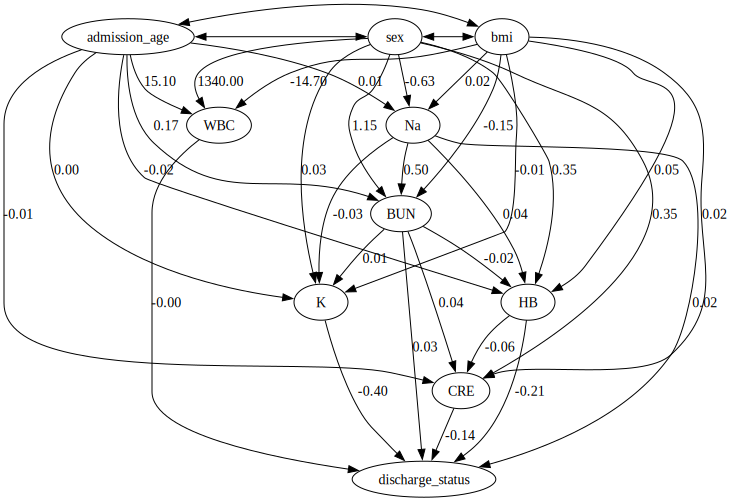

In [4]:
vars = exog_var_names + endog_var_names + [sink_var_name]
B_exog = pd.DataFrame(
    [
        [0, np.nan, np.nan],
        [np.nan, 0, np.nan],
        [np.nan, np.nan, 0],
    ],
    index=exog_var_names,
    columns=exog_var_names,
)

#--- Overall adj matrix
adj = pd.DataFrame(0.0, index=vars, columns=vars)
adj.loc[B_exog.index, B_exog.columns] = B_exog
adj.loc[W_endog.index, W_endog.columns] = W_endog
adj.loc[B_endog.index, B_endog.columns] = B_endog
adj.loc[W_sink.index, W_sink.columns] = W_sink

make_dot(adj, adj.columns.tolist(), lower_limit=0)

### Function to Simulate age, bmi and sex

- age and bmi are drawn from Gamma distributions
- Sex is drawn from binomial distribution
- Correlation is reproduced from a Gaussian copula

In [5]:
def simulate_exog(mean1, var1, mean2, var2, p_binary, corr_matrix, n=1000):
    # --- Determine Parameters for Target Marginal Distributions ---
    # For the Gamma distribution (a good choice for positive, skewed data)
    # We can calculate the shape and scale from the mean and variance
    scale1 = var1 / mean1
    shape1 = mean1 / scale1

    scale2 = var2 / mean2
    shape2 = mean2 / scale2

    # For the Bernoulli (binary) distribution, the parameter 'p' is just the mean
    p_binary_param = p_binary

    # --- The Gaussian Copula Simulation ---

    # Generate from a multivariate normal with the derived correlation
    multivariate_norm = stats.multivariate_normal(mean=[0, 0, 0], cov=corr_matrix)
    correlated_norm_samples = multivariate_norm.rvs(size=n)

    # Transform to uniform samples using the CDF
    correlated_uniform_samples = stats.norm.cdf(correlated_norm_samples)

    # Transform uniform samples to our target marginal distributions using the PPF
    var1_simulated = stats.gamma.ppf(correlated_uniform_samples[:, 0], a=shape1, scale=scale1)
    var2_simulated = stats.gamma.ppf(correlated_uniform_samples[:, 1], a=shape2, scale=scale2)
    var3_simulated_binary = stats.bernoulli.ppf(correlated_uniform_samples[:, 2], p=p_binary_param)
    print("Simulation complete.\n")

    df_exog_simulated = pd.DataFrame({
    'admission_age': var1_simulated,
    'bmi': var2_simulated,
    'sex': var3_simulated_binary})

    return df_exog_simulated


### Simulate Error Term of Emdogenous Variables Residuals (Innovations)

- Assumption: The error terms of the endogenous variables residuals are independent.
- Innovations are generated from a Laplace distribution due to LiNGAM assumptions

In [6]:
def simulate_laplace_innovations(n=1000):
    """
    Simulates innovations from 6 independent Laplace distributions with specified variances.

    Args:
        n (int): The number of samples (rows) to generate.

    Returns:
        pd.DataFrame: A DataFrame with n rows and 6 columns, where each column
                      contains samples from a Laplace distribution with the
                      corresponding desired variance.
    """
    # --- 1. Define Parameters ---
    num_distributions = 6

    # Specify a unique desired variance for each of the 6 distributions
    desired_variances = np.array([260, 0.5, 3.3, 0.36, 32, 4.4 * 10**8])
    column_names = ['BUN', 'CRE', 'HB', 'K', 'Na', 'WBC']

    # --- 2. Calculate the required 'scale' for each variance ---
    # The variance of the Laplace distribution is 2 * (scale**2).
    # Therefore, scale = sqrt(variance / 2).
    scales = np.sqrt(desired_variances / 2)

    # --- 3. Generate the Samples ---
    # Generate samples from the Laplace distribution.
    # The 'loc' parameter is the mean, which defaults to 0.
    # Broadcasting applies the i-th scale to the i-th column of samples.
    samples = laplace.rvs(scale=scales, size=(n, num_distributions))
    df_innovations = pd.DataFrame(data=samples, columns=column_names)

    return df_innovations

### Function to Simulate Dataset

- Endogenous variables are derived as follows
$$Y = W_{endog} * X_{exog} + E_{endog}$$

$W_{endog}$: Regression coefficients from exogenous variables to endogenous variables

$X_{exog}$: Simulated exogenous variables

Where by,
$$E_{endog} = (I - B_{endog})^{-1} * Innovations$$

$I$: Unit matrix

$B_{endog}$: Adjacency matrix for the endogenous variables residuals

$Innovation$: Error term for the simulated endogenous variables

- Endogenous variables are derived from simulated exogenous variables and innovations

In [7]:
def simulate_from_model(endog_var_names, sink_var_name, intercept_endog, B_endog, W_endog, intercept_sink, W_sink, simulated_exog):
    """
    Simulates endogenous and sink variables from a trained LiNGAM-based SEM.

    Args:
        sink_model (LogisticRegression): The trained logistic regression model for the sink variable.
        B_endog (pd.DataFrame): Adjacency matrix for relationships among endogenous variables.
        W_endog (pd.DataFrame): Coefficients for the effect of exogenous on endogenous variables.
        W_sink (pd.DataFrame): Coefficients for the effect of endogenous on the sink variable.
        simulated_exog (pd.DataFrame): A DataFrame with simulated values for the exogenous variables.

    Returns:
        pd.DataFrame: A DataFrame containing the simulated endogenous and sink variables.
    """
    n_samples = len(simulated_exog)

    # --- 1. Simulate Innovations for Endogenous Variables ---
    simulated_innovations = simulate_laplace_innovations(n=n_samples)
    
    # --- 2. Simulate Endogenous Variables ---
    # The full structural equation for the endogenous variables (Y) is:
    # Y = W_endog * X_exog + E_endog
    # where E_endog = (I - B_endog)^-1 * Innovations
    
    # First, calculate the part of Y determined by other endogenous variables
    I = np.identity(B_endog.shape[0])
    B_inv = np.linalg.inv(I - B_endog.values)
    
    # Calculate the simulated residuals (E_endog)
    simulated_residuals_endog = simulated_innovations @ B_inv.T
    simulated_residuals_endog.columns = endog_var_names

    # Second, calculate the part of Y determined by exogenous variables
    # Note: We use .T to align matrix dimensions for multiplication
    effect_from_exog = simulated_exog @ W_endog.T
    effect_from_exog = effect_from_exog.to_numpy() + intercept_endog.T.to_numpy()
    effect_from_exog = pd.DataFrame(data=effect_from_exog, columns=endog_var_names)

    # Combine the effects to get the final simulated endogenous variables
    # convert to abs value
    simulated_endog = effect_from_exog + simulated_residuals_endog
    simulated_endog[endog_var_names] = simulated_endog[endog_var_names].abs()

    # --- 3. Simulate the Sink Variable ---
    # The sink is determined by a logistic regression on the endogenous residuals.
    # P(Sink=1) = sigmoid(W_sink * E_endog + intercept)
    
    # Calculate the log-odds (the linear part of the logistic model)
    log_odds = simulated_residuals_endog @ W_sink.T + intercept_sink
    
    # Convert log-odds to probabilities using the sigmoid function
    probabilities = expit(log_odds)
    
    # Simulate the binary outcome (0 or 1) using the calculated probabilities
    random_values = np.random.rand(n_samples, 1)
    simulated_sink = (random_values < probabilities.values).astype(int)
    simulated_sink = pd.DataFrame(simulated_sink, columns=[sink_var_name])

    # --- 4. Combine and Return Results ---
    final_simulation = pd.concat([simulated_exog, simulated_endog, simulated_sink], axis=1)
    
    return final_simulation

In [8]:
df_exog_simulated = simulate_exog(mean1, var1, mean2, var2, p_binary, corr_matrix, n=1000)
df_simulated = simulate_from_model(
    endog_var_names, 
    sink_var_name, 
    intercept_endog, 
    B_endog, 
    W_endog, 
    intercept_sink, 
    W_sink, 
    df_exog_simulated)

Simulation complete.



### Mean, Variance, and Correlation Matrix of Simulated Dataset

In [9]:
print(df_simulated.agg(['mean', 'var']).round(2))
print("Derived Correlation Matrix:\n", np.round(df_simulated.corr(), 2), "\n")

      admission_age   bmi  sex    BUN  CRE    HB    K     Na          WBC  \
mean          83.48 20.92 0.34  25.94 1.21 11.60 3.99 136.65     18931.18   
var           64.31 15.19 0.22 181.40 0.59  3.28 0.46  28.87 225814018.07   

      discharge_status  
mean              0.04  
var               0.04  
Derived Correlation Matrix:
                   admission_age   bmi   sex   BUN   CRE    HB     K    Na  \
admission_age              1.00 -0.17 -0.15  0.10 -0.09 -0.18 -0.01  0.04   
bmi                       -0.17  1.00  0.00 -0.00  0.09  0.17 -0.06  0.05   
sex                       -0.15  0.00  1.00  0.03  0.23  0.12  0.00 -0.05   
BUN                        0.10 -0.00  0.03  1.00  0.52 -0.13  0.20  0.18   
CRE                       -0.09  0.09  0.23  0.52  1.00 -0.11  0.06  0.05   
HB                        -0.18  0.17  0.12 -0.13 -0.11  1.00 -0.09  0.08   
K                         -0.01 -0.06  0.00  0.20  0.06 -0.09  1.00 -0.24   
Na                         0.04  0.05 -0.05  0.1

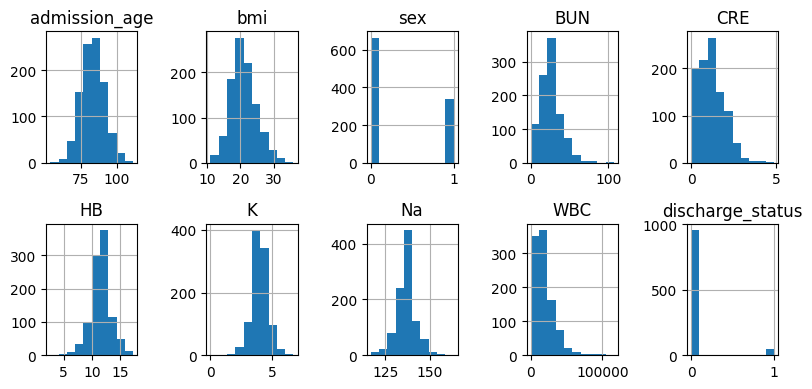

In [10]:
df_simulated.hist(layout=(2, 5), figsize=(8, 4))
plt.tight_layout()
plt.show()

## Analysis

### Estimation of Causal Graph

In [11]:
X = df_simulated.copy()
X['sex'] = X['sex'].astype('int')
X['WBC'] = X['WBC'] / 1000

# Perform causal discovery
X_removed_exog = X.copy()

# record coefficients of linear regressions
W_endog = []
intercept_endog = []

# remove effects of exogenous variables from X by regression
for endog_var_name in endog_var_names:
    # fitting a linear regression model
    reg = LinearRegression()
    reg.fit(X[exog_var_names], X[endog_var_name])
    
    # remove effects of exogenous variables from other variables
    X_removed_exog[endog_var_name] = X[endog_var_name] - reg.predict(X[exog_var_names])
    
    W_endog.append(reg.coef_)
    intercept_endog.append(reg.intercept_)

W_endog = pd.DataFrame(W_endog, index=endog_var_names, columns=exog_var_names)
intercept_endog = pd.DataFrame(intercept_endog, index=endog_var_names)

#--- endogenous variable
cd_model = DirectLiNGAM()
cd_model.fit(X_removed_exog[endog_var_names])

B_endog = pd.DataFrame(cd_model.adjacency_matrix_, index=endog_var_names, columns=endog_var_names)

#--- sink variable
sink_model = LogisticRegression(penalty=None, max_iter=10_000)
sink_model.fit(X_removed_exog[endog_var_names], X_removed_exog[sink_var_name])

W_sink = pd.DataFrame(sink_model.coef_, index=[sink_var_name], columns=endog_var_names)

#--- exog variable adj matrix
B_exog = pd.DataFrame(
    [
        [0, np.nan, np.nan],
        [np.nan, 0, np.nan],
        [np.nan, np.nan, 0],
    ],
    index=exog_var_names,
    columns=exog_var_names,
)

#--- Overall adj matrix
adj = pd.DataFrame(0.0, index=X.columns, columns=X.columns)
adj.loc[B_exog.index, B_exog.columns] = B_exog
adj.loc[W_endog.index, W_endog.columns] = W_endog
adj.loc[B_endog.index, B_endog.columns] = B_endog
adj.loc[W_sink.index, W_sink.columns] = W_sink


<div class="alert alert-block alert-info">
<b>Vocabulary Adjacency Matrix</b> 

An adjacency matrix shows the existence of a causal relationship from one variable (column) to another variable (row), which corresponds to the presence of a directed edge in a DAG.　The entries in the matrix can either be the actual regression coefficients or ternary values (-1, 0, 1) indicating the presence and sign of an effect (e.g., negative, none, or positive).
</div>

#### Overall Adjacency Matrix (Exogenous, Endogenous, and Sink Variables)

In [12]:
display(HTML(adj.to_html()))

,admission_age,bmi,sex,BUN,CRE,HB,K,Na,WBC,discharge_status
admission_age,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00
bmi,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00
sex,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
BUN,0.18,0.06,1.17,0.00,0.00,0.00,0.00,0.44,0.00,0.00
CRE,-0.00,0.02,0.36,0.03,0.00,-0.05,0.00,0.00,0.00,0.00
HB,-0.03,0.07,0.37,-0.02,0.00,0.00,0.00,0.04,0.00,0.00
K,-0.00,-0.01,-0.00,0.01,0.00,0.00,0.00,-0.03,0.00,0.00
Na,0.03,0.08,-0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00
WBC,0.03,0.05,0.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00
discharge_status,0.00,0.00,0.00,0.03,-0.12,-0.13,-0.57,-0.04,-0.04,0.00


#### Adjacency Matrix Representing Causal Relationship between Exogenous and Endogenous Variables

- Examples of How to Interpret the Data
    - Here we see how age, BMI, and gender can influence blood test results.
    - Older individuals may have higher WBC counts, which suggests  more significant inflammation and a greater risk of developing a severe condition.
    - Men often show higher BUN and creatinine levels; this could be due to either reduced kidney function or a larger muscle volume.

In [13]:
display(HTML(W_endog.to_html()))

,admission_age,sex,bmi
BUN,0.18,1.17,0.06
CRE,-0.00,0.36,0.02
HB,-0.03,0.37,0.07
K,-0.00,-0.00,-0.01
Na,0.03,-0.52,0.08
WBC,0.03,0.61,0.05


#### Adjacency Matrix Representing Causal Relationship within Endogenous Variables

- Examples of How to Interpret the Data
    - BUN levels rise following hypernatremia, suggesting hypertonic dehydration.
    - Cre is downstream of BUN, indicating a susceptibility to renal impairment.
    - Hb should increase along with BUN, however results show otherwise

In [14]:
display(HTML(B_endog.to_html()))

,BUN,CRE,HB,K,Na,WBC
BUN,0.00,0.00,0.00,0.00,0.44,0.00
CRE,0.03,0.00,-0.05,0.00,0.00,0.00
HB,-0.02,0.00,0.00,0.00,0.04,0.00
K,0.01,0.00,0.00,0.00,-0.03,0.00
Na,0.00,0.00,0.00,0.00,0.00,0.00
WBC,0.00,0.00,0.00,0.00,0.00,0.00


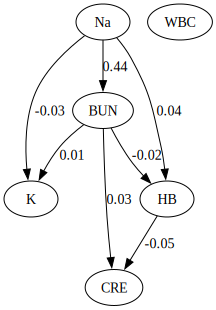

In [15]:
# Causal Graph
make_dot(B_endog, labels=endog_var_names)

#### Adjacency Matrix Representing Causal Relationship between Endogenous and Sink Variables

- Examples of How to Interpret the Data
    - Increased mortality by elevated Na and BUN reflects hypertonic dehydration, common in the elderly due to insufficient water intake.
    - A decrease in mortality is seen as creatinine levels rise, suggesting that CRE reflects muscle mass, not just renal function.
    - WBC count does not significantly change mortality.

In [16]:
display(HTML(W_sink.to_html()))

,BUN,CRE,HB,K,Na,WBC
discharge_status,0.03,-0.12,-0.13,-0.57,-0.04,-0.04


#### Causal Graph

- Examples of How to Interpret the Data
    - A comprehensive overview reveals that Sodium (Na) is an upstream factor influencing mortality through various pathways.
    - This suggests a hypothesis that dehydration severe enough to cause hypernatremia likely contributes to the mortality risk in pyelonephritis.
    - Conversely, it is hypothesized that White Blood Cell (WBC) count has little effect on mortality and merely indicates the presence or absence of an infection.

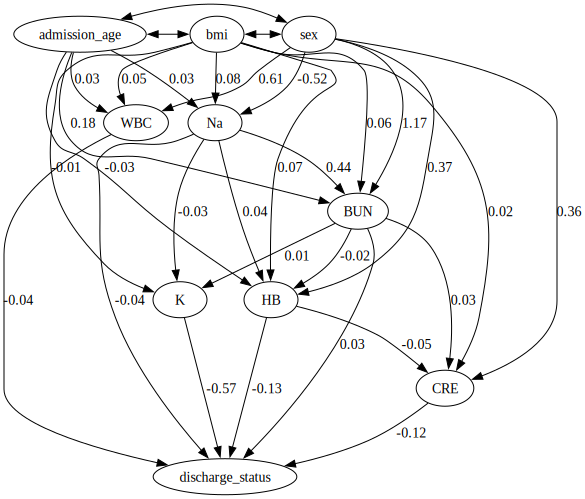

In [17]:
# Causal Graph
make_dot(adj, labels=adj.columns.tolist())

#### Model Evaluation

- Evaluate causal graph as structured equation model(SEM) and output various metrics
- The causal structure is fixed by LiNGAM and the parameters are re-estimated using SEM
- This measure of fit is based solely on the covariance structure and is intended for reference purposes only.

In [18]:
def calc_fit_indices_structure_only(
    B, X, exog_var_names,
    ordinal_vars=('sex','discharge_status')  # explicitly state ordinal variables
):
    """
    Evaluate goodness of fit by covariance structure only (no mean structure included)
    - The causal structure (the presence or absence of edges) is fixed, while the coefficients are freely estimated by semopy.
    - The covariances between exogenous variables are freely estimated (to avoid redundancy).
    - Columns specified in ordinal_vars are treated as ordinal variables.
    """
    # exclude exogenous variables from dependent variables
    B_use = B.copy().drop(exog_var_names, axis=0)

    desc = ""
    # structure only; no coefficients
    for name, row in B_use.iterrows():
        parents = [p for p, coef in row.items() if not np.isclose(coef, 0)]
        if parents:
            desc += f"{name} ~ " + " + ".join(parents) + "\n"

    # covariance between exogenous variables (avoid duplicate by upper triangle)
    exogs = [v for v in exog_var_names if v in X.columns]
    for i, a in enumerate(exogs):
        others = [b for j, b in enumerate(exogs) if j > i]
        if others:
            desc += a + " ~~ " + " + ".join(others) + "\n"

    # explicitly state ordinal type (not implicitly by dtype)
    ords = [v for v in ordinal_vars if v in X.columns]
    if ords:
        desc += "DEFINE(ordinal) " + " ".join(ords) + "\n"

    # fit covariance structure onlu
    m = semopy.Model(desc)
    m.fit(X)
    return semopy.calc_stats(m)

X_eval = X_removed_exog.copy()
X_eval[sink_var_name] = X[sink_var_name]

fit_indices = calc_fit_indices_structure_only(
    adj, X_eval, exog_var_names,
    ordinal_vars=('sex','discharge_status')
)
fit_indices

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,14,48,91.32,0.00,1129.96,0.93,0.92,0.72,0.92,0.75,0.07,81.82,283.04,0.09


### Evaluating the Reliability of Causal Graph by Bootstrap Method

#### Preparation

In [19]:
# Analysis with bootstrap
def run_analysis(X, exog_var_names, endog_var_names, sink_var_name, cd_model=None, sink_model=None):
    """
    X : pandas.DataFrame
        That data type must be float or int. Variables of type int are interpreted as discrete.
    exog_var_names : list of str
        List of names of exogenous variables.
    endog_var_names : list of str
        List of names of endogenous variables.
    sink_var_name : str
        Name of the sink variable.
    cd_model : object
        Instance of LiNGAM model.
    sink_model : object
        Instance of a model for the sink variable.
    """
    # check X
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X must be pandas.DataFrame.")
    
    # check lists of variable names
    if len(set(exog_var_names) - set(X.columns)) > 0:
        raise ValueError("exog_var_names includes unknown variables.")
    
    if len(set(endog_var_names) - set(X.columns)) > 0:
        raise ValueError("endog_var_names includes unknown variables.")
        
    if len(set([sink_var_name]) - set(X.columns)) > 0:
        raise ValueError("sink_var_name is unknown variables.")

    # check cd_model
    if cd_model is None:
        cd_model = DirectLiNGAM()
    else:
        if isinstance(cd_model, DirectLiNGAM):
            pass
        else:
            # other models aren't supported.
            raise ValueError("Unsupported cd_model")
    
    # preprocess X
    exog_indices = [X.columns.tolist().index(v) for v in exog_var_names]
    endog_indices = [X.columns.tolist().index(v) for v in endog_var_names]
    sink_index = X.columns.tolist().index(sink_var_name)
    
    is_discrete = X.dtypes == int
    if is_discrete[endog_indices].any():
        raise ValueError("endog_var_names mustn't be a discrete variable. Convert types of variables specified in endog_var_names.")
    
    names = X.columns.tolist()
    
    X = check_array(X, copy=True)
    
    if sink_model is None:
        if is_discrete[sink_index]:
            sink_model = LogisticRegression()
        else:
            sink_model = LinearRegression()
    
    # perform causal discovery
    X_removed_exog, W_endog = remove_effect(X, exog_indices, return_coefs=True)
    X_endog = X_removed_exog[:, endog_indices]
    
    del W_endog[sink_index]
    W_endog = pd.DataFrame(W_endog.values(), index=endog_var_names, columns=exog_var_names)
    
    B_exog = np.eye(len(exog_var_names)) - 1
    B_exog[B_exog == -1] = np.nan
    B_exog = pd.DataFrame(B_exog, index=exog_var_names, columns=exog_var_names)
    
    cd_model.fit(X_endog)
    B_endog = pd.DataFrame(cd_model.adjacency_matrix_, index=endog_var_names, columns=endog_var_names)
    
    # model for the given sink variable
    sink_model.fit(X[:, endog_indices], X[:, sink_index])
    W_sink = pd.DataFrame(sink_model.coef_, index=[sink_var_name], columns=endog_var_names)

    # make one adjacency matrix
    names = W_endog.columns.tolist() + B_endog.index.tolist() + W_sink.index.tolist()
    adj = pd.DataFrame(0.0, index=names, columns=names)
    adj.loc[B_exog.index, B_exog.columns] = B_exog
    adj.loc[W_endog.index, W_endog.columns] = W_endog
    adj.loc[B_endog.index, B_endog.columns] = B_endog
    adj.loc[W_sink.index, W_sink.columns] = W_sink
    
    return adj

#### Bootstrap Sampling & Generating Results
- bootstrap sample size should be at least more than 200

In [20]:
# number of bootstrapping
# n=100, 80mins

n_sampling = 10

# number of features
n_features = X.shape[1]

# container of a result
adjs = np.zeros((n_sampling, n_features, n_features))
total_effects = np.zeros((n_sampling, n_features, n_features))
fit_indices_df = []

# perform bootstrapping
for i in range(n_sampling):
    print("\r", i, end="")
    
    # error when sink var is all 0
    while True:
        X_resampled = resample(X, replace=True)
        if X_resampled[sink_var_name].nunique() == 2:
            break
        else:
            print('resample retry')
    
    # causal discovery on endogenous variabels and a sink variable
    adj = run_analysis(
        X_resampled,
        exog_var_names,
        endog_var_names,
        sink_var_name,
        sink_model=LogisticRegression()
    )
    adjs[i] = adj

    # calc causal order
    dag = nx.from_numpy_array(adj.fillna(0).values.T, create_using=nx.DiGraph)
    causal_order = list(nx.topological_sort(dag))

    # calc causal effects
    for c, from_ in enumerate(causal_order):
        for to in causal_order[c + 1 :]:
            total_effects[i, to, from_] = calculate_total_effect(
                adj.values, from_, to
            )
    
    fit_indices = calc_fit_indices_structure_only(adj, X_resampled, exog_var_names)
    fit_indices_df.append(fit_indices)
print("\r\n")

# store results
result = BootstrapResult(adjs, total_effects)

fit_indices_df = pd.concat(fit_indices_df)

 5

 9



#### Bootstrap Probability

- The probability of a directed edge from one variable to another.
- The causality from exogenous variables to endogenous variables has a high degree of certainty.

In [21]:
# bootstrap probability
prob = result.get_probabilities(min_causal_effect=0.01)
df_prob = pd.DataFrame(prob, index=X.columns, columns=X.columns)
df_prob

,admission_age,bmi,sex,BUN,CRE,HB,K,Na,WBC,discharge_status
admission_age,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
bmi,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
sex,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
BUN,1.00,1.00,1.00,0.00,0.00,0.20,0.00,0.70,0.00,0.00
CRE,0.00,1.00,1.00,1.00,0.00,1.00,0.20,0.10,0.00,0.00
HB,1.00,1.00,1.00,0.70,0.00,0.00,0.00,0.50,0.10,0.00
K,0.00,0.90,0.50,0.90,0.10,0.20,0.00,0.80,0.00,0.00
Na,1.00,1.00,0.90,0.20,0.00,0.10,0.20,0.00,0.30,0.00
WBC,0.90,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
discharge_status,0.00,0.00,0.00,0.90,1.00,1.00,1.00,0.90,1.00,0.00


#### Probability of Causal Direction
- Outputs the top 10 pairs with the highest existence probability.
- This is the output from ranking the adjacency matrix mentioned above.

In [22]:
# causal directions
# variable names of an estimated adjacency matrix
var_names = X_removed_exog.columns.tolist() + [sink_var_name]

cdc = result.get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=False)
print_causal_directions(cdc, n_sampling, labels=var_names)

BUN <--- admission_age  (100.0%)
discharge_status <--- K  (100.0%)
discharge_status <--- HB  (100.0%)
discharge_status <--- CRE  (100.0%)
WBC <--- sex  (100.0%)
WBC <--- bmi  (100.0%)
Na <--- bmi  (100.0%)
Na <--- admission_age  (100.0%)
HB <--- sex  (100.0%)
HB <--- bmi  (100.0%)


#### Most Frequent Causal Graph from Bootstrapping
- The proportion of times an identical, ternary valued (-1, 0, 1) adjacency matrix appeared.

- 3 most frequent causal graphs

In [23]:
# DAG
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling=n_sampling, labels=var_names)

DAG[0]: 10.0%
	BUN <--- admission_age (b>0)
	BUN <--- bmi (b<0)
	BUN <--- sex (b>0)
	BUN <--- Na (b>0)
	CRE <--- bmi (b>0)
	CRE <--- sex (b>0)
	CRE <--- BUN (b>0)
	CRE <--- HB (b<0)
	HB <--- admission_age (b<0)
	HB <--- bmi (b>0)
	HB <--- sex (b>0)
	HB <--- BUN (b<0)
	HB <--- Na (b>0)
	K <--- bmi (b<0)
	K <--- BUN (b>0)
	K <--- Na (b<0)
	Na <--- admission_age (b>0)
	Na <--- bmi (b<0)
	Na <--- sex (b>0)
	WBC <--- admission_age (b<0)
	WBC <--- bmi (b>0)
	WBC <--- sex (b<0)
	discharge_status <--- BUN (b>0)
	discharge_status <--- CRE (b>0)
	discharge_status <--- HB (b<0)
	discharge_status <--- K (b<0)
	discharge_status <--- WBC (b<0)
DAG[1]: 10.0%
	BUN <--- admission_age (b>0)
	BUN <--- bmi (b>0)
	BUN <--- sex (b<0)
	BUN <--- HB (b<0)
	CRE <--- bmi (b>0)
	CRE <--- sex (b>0)
	CRE <--- BUN (b>0)
	CRE <--- HB (b<0)
	HB <--- admission_age (b<0)
	HB <--- bmi (b>0)
	HB <--- sex (b>0)
	K <--- bmi (b>0)
	K <--- sex (b<0)
	K <--- HB (b<0)
	Na <--- admission_age (b>0)
	Na <--- bmi (b<0)
	Na <--- sex

- Visualizing the most frequent causal graph

In [24]:
def create_signed_adjacency_matrix(data):
    """
    Creates a signed adjacency matrix from a dictionary of graph edges.

    Args:
        data (dict): A dictionary with 'from', 'to', and 'sign' keys,
                     each containing a list of the same length.
                     'from': list of source nodes (int).
                     'to': list of destination nodes (int).
                     'sign': list of edge signs (+1 or -1).

    Returns:
        numpy.ndarray: The resulting signed adjacency matrix.
    """
    # Combine 'from' and 'to' lists to find the highest node index
    all_nodes = data['from'] + data['to']
    if not all_nodes:
        return np.array([]) # Return an empty matrix if there are no nodes

    # Determine the number of nodes. Since nodes are 0-indexed,
    # the size of the matrix is max_node + 1.
    num_nodes = max(all_nodes) + 1

    # Initialize an NxN matrix with zeros, where N is the number of nodes.
    # The data type is set to integer.
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    # Iterate through the edges and populate the matrix
    # The zip function pairs up elements from the 'from', 'to', and 'sign' lists
    # column: from, row: to
    for u, v, sign in zip(data['to'], data['from'], data['sign']):
        # Assign the sign to the matrix at the position (row u, column v)
        adjacency_matrix[u, v] = sign

    return adjacency_matrix

# Example input data provided by the user
edge_data = dagc['dag'][0]

# Generate the adjacency matrix
signed_matrix = create_signed_adjacency_matrix(edge_data)
df_signed_matrix = pd.DataFrame(signed_matrix, index=X.columns, columns=X.columns)

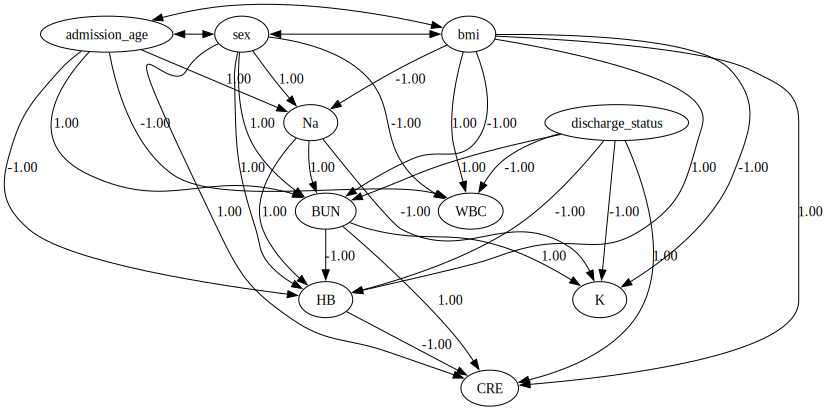

In [25]:
B_exog = pd.DataFrame(
    [
        [0, np.nan, np.nan],
        [np.nan, 0, np.nan],
        [np.nan, np.nan, 0],
    ],
    index=exog_var_names,
    columns=exog_var_names,
)
W_endog = df_signed_matrix.loc[endog_var_names, exog_var_names]
B_endog = df_signed_matrix.loc[endog_var_names, endog_var_names]
W_sink = pd.DataFrame(df_signed_matrix.loc[sink_var_name, endog_var_names])


adj = pd.DataFrame(0.0, index=vars, columns=vars)
adj.loc[B_exog.index, B_exog.columns] = B_exog
adj.loc[W_endog.index, W_endog.columns] = W_endog
adj.loc[B_endog.index, B_endog.columns] = B_endog
adj.loc[W_sink.index, W_sink.columns] = W_sink

make_dot(adj, adj.columns.tolist(), lower_limit=0)

In [26]:
df_signed_matrix

,admission_age,bmi,sex,BUN,CRE,HB,K,Na,WBC,discharge_status
admission_age,0,0,0,0,0,0,0,0,0,0
bmi,0,0,0,0,0,0,0,0,0,0
sex,0,0,0,0,0,0,0,0,0,0
BUN,1,-1,1,0,0,0,0,1,0,0
CRE,0,1,1,1,0,-1,0,0,0,0
HB,-1,1,1,-1,0,0,0,1,0,0
K,0,-1,0,1,0,0,0,-1,0,0
Na,1,-1,1,0,0,0,0,0,0,0
WBC,-1,1,-1,0,0,0,0,0,0,0
discharge_status,0,0,0,1,1,-1,-1,0,-1,0


#### Total Causal Effect & Probability
- The bootstrap median of the causal effect between two variables, as calculated from the adjacency matrix.
- The probability that the causal effect between two variables is non-zero, as calculated from the adjacency matrix.
- This quantifies the influence on the `to` element by changing the `from` element.

- Examples of How to Interpret the Data
    - There is a high certainty that low Hemoglobin (Hb), high BUN, and low Potassium (K) impact mortality.
    - This suggests that anemia and dehydration may increase mortality risk.

In [27]:
# total causal effect
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

df = pd.DataFrame(causal_effects)
df['from'] = df['from'].apply(lambda x : var_names[x])
df['to'] = df['to'].apply(lambda x : var_names[x])
display(df)

,from,to,effect,probability
0,admission_age,BUN,0.21,1.00
1,K,discharge_status,-0.50,1.00
2,HB,discharge_status,-0.11,1.00
3,CRE,discharge_status,0.01,1.00
4,sex,WBC,0.09,1.00
5,bmi,WBC,0.74,1.00
6,bmi,Na,-0.56,1.00
7,sex,HB,0.07,1.00
8,bmi,HB,0.34,1.00
9,admission_age,HB,-0.04,1.00


#### Bootstrap Probability of a Given Path
- Calculates the bootstrap probability of a path between two specified variables.
- Examples of How to Interpret the Data
    - The effect of BMI on mortality is largely mediated through Hb (Hemoglobin), and this path has a high degree of certainty.
        - This generates the hypothesis that obesity contributes to mortality through anemia.

In [28]:
# Bootstrap Probability of Path
from_var_name = "bmi"
to_var_name = "discharge_status"
display(Markdown(f"#### {from_var_name}→{to_var_name}"))

path = result.get_paths(var_names.index(from_var_name), var_names.index(to_var_name))
path = pd.DataFrame(path)

path["path"] = path["path"].apply(lambda indices: [var_names[i] for i in indices])
pd.set_option('display.float_format', '{:.5f}'.format)
path.sort_values('effect').query('abs(effect) > 0.0001')

#### bmi→discharge_status

,path,effect,probability
2,"[bmi, HB, discharge_status]",-0.03579,1.00000
7,"[bmi, WBC, discharge_status]",-0.03433,1.00000
6,"[bmi, BUN, K, discharge_status]",-0.00713,1.00000
48,"[bmi, CRE, K, Na, discharge_status]",-0.00571,0.10000
9,"[bmi, Na, K, discharge_status]",-0.00514,0.80000
30,"[bmi, BUN, Na, discharge_status]",-0.00414,0.20000
43,"[bmi, HB, Na, discharge_status]",-0.00382,0.10000
41,"[bmi, HB, BUN, discharge_status]",-0.00316,0.20000
13,"[bmi, Na, BUN, discharge_status]",-0.00188,0.70000
52,"[bmi, WBC, K, Na, discharge_status]",-0.00117,0.10000
